We need to first get a better understanding of our audio data. Here we will look at some key concepts and features of audio data.

Let's think about the digital representation of analog sound. How does sound get recorded anyway?! Just like with images we need to take our physical world and convert it to numbers or a digital representation for a computer to understand. For audio, a microphone is used to capture the sound and then it's converted from analog sound to digital sound by sampling at consistent intervals of time. This is called the `sample rate`. The higher the `sample rate` the higher the quality of the sound; however after a certain point the difference is not able to be detected by the human ear. The average sound sample rate is 48 kHz or 48,000 samples per second. The dataset we'll use in this module was sampled at 16kHz, so our data was sampled 16,000 times per second.

When we sample audio, we measure the `amplitude` or how loud the audio is, at a particular sample rate. We can then take that information and represent the `signal` in graphical format as a `waveform`. Another way to look at the audio information is by analyzing its `frequency` or pitch, which represents the number of complete waves per time period -- the more waves, the higher the pitch! Also, audio can be recorded in different `channels`. For example stereo recordings have 2 channels, right and left.

Now that we understand a bit about how we get our audio file, let's take a moment to understand how we might want to parse out a file. If you have longer audio files, you may want to split it out into `frames` or sections of the audio to be classified individually. For this dataset we don't need to split the data into frames because each sample is only one second and one word. Another processing step might be an `offset` which means the number of frames from the start of the file to begin data loading.


## Import

Lets get started! First we will import the packages needed:

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipd

## Get the speech commands dataset

We will use a tensorflow dataset called [Speech Commands](https://www.tensorflow.org/datasets/catalog/speech_commands). We will download the dataset but we are going to only use the `yes` and `no` classes to create a binary classification model.

Now we extract the data from a local data path:

In [2]:
# This method is used for the local dataset that has already been downloaded to the Learn enviornment.
tf.keras.utils.get_file(
     'speech_commands_v0.02.tar.gz',
      origin = "./data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data')

'.\\data\\speech_commands_v0.02.tar.gz'

If you are going to run this notebook locally on your own machine, use the below code to download a smaller subset of the data from googe storage.

In [ ]:
## This method is for local development to download from the public storage location.
#
# data_dir = pathlib.Path('./data/mini_speech_commands')
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

In [3]:
# Change directory to downloaded data
os.chdir('./data')
default_dir = os.getcwd()
print(f'Data directory will be: {default_dir}')

Data directory will be: c:\Users\domin\Coding\Audio Data Science\Microsoft-Intro Audio Classification Tensorflow\data


In [4]:
def load_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split("_nohash_")
        utterance_number = int(utterance_number)
    
        # Load audio
        waveform, sample_rate = load_audio(file_path)
        dataset.append([waveform, sample_rate, label, speaker_id, utterance_number])
        
    return dataset


### Visualize the classes available in the dataset

In [5]:
labels = [name for name in os.listdir('.') if os.path.isdir(name)]
# back to default directory
os.chdir(default_dir)
print(f'Total Labels: {len(labels)}')
print(f'Label Names: {labels}')

Total Labels: 36
Label Names: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero', '_background_noise_']


In [6]:
filenames = tf.io.gfile.glob(str(default_dir) + '/*/*')
num_samples = len(filenames)
print('Number of total examples:', num_samples)

Number of total examples: 105836


## Convert the sound to tensor

You likely have used a wave file before and understand that this is one format in which we save our digital representation of our analog audio to be shared and played. The Speech Commands dataset that we are using for this tutorial is stored in wave files that are all one second or less.

Let's load up one of the wave files and take a look at how the tensor for the `waveform` looks. We will do this by creating and calling a `load_audio` function that will read the wave audio file and return the `waveform` tensor and `sample_rate`. The function gets the `audio_binary` with [tf.io.read_file](https://www.tensorflow.org/api_docs/python/tf/io/read_file) then uses [tf.audio.decode_wav](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav) to get the audio `waveform` to a tensor format (range of: -1 to 1) and the `sample_rate`.


In [7]:
file_path = "./yes/00f0204f_nohash_0.wav"

def load_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate.numpy()

waveform, sample_rate = load_audio(file_path)
print('Waveform Tensor:', waveform)
print('Sample Rate:', sample_rate)

Waveform Tensor: tf.Tensor([0.00048828 0.00067139 0.00054932 ... 0.00079346 0.00082397 0.00067139], shape=(16000,), dtype=float32)
Sample Rate: 16000


## Plot the waveform

Below we will create a `plot_audio` function to display the waveform and listen to a sample of each class.

In [8]:
def plot_audio(filename):
    waveform, sample_rate = load_audio(filename)

    plt.figure()
    plt.plot(waveform.numpy())

    return waveform, sample_rate

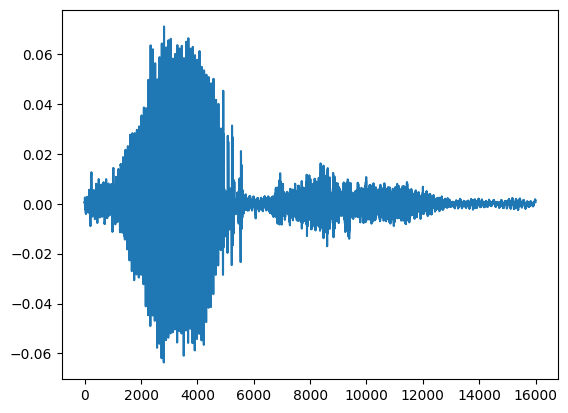

In [9]:
filename = "./yes/00f0204f_nohash_0.wav"
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)

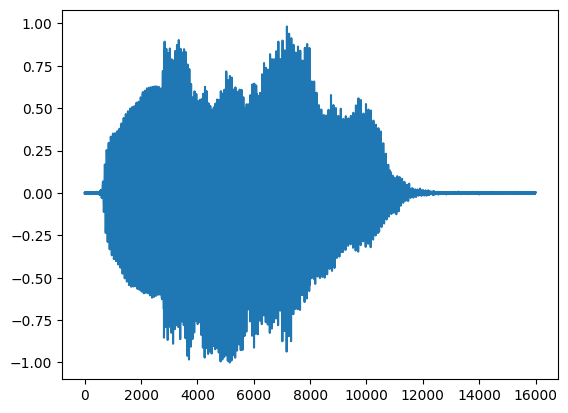

In [10]:
filename = "./no/0c2ca723_nohash_0.wav"
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)